In [139]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

class MyBinaryLogisticRegression:
    def __init__(self, weight_calc='gd', regularization=None, epochs=1000, eta=0.01, lambda_1=0.01, lambda_2=0.01, batch_size=20):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регулризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регулризации l2 не задано")
        
        self.coefs_ = None
        self.feature_names_in_ = None
        self.loss_array = None
        self.weight_calc = weight_calc
        self.epochs = epochs
        self.eta = eta
        self.regularization = regularization
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size

    def regularize(self, gradients, w):
        if self.regularization == 'l1':
            gradients[1:] += self.lambda_1 * np.sign(w[1:])
        elif self.regularization == 'l2':
            gradients[1:] += 2 * self.lambda_2 * w[1:]
        elif self.regularization == 'l1l2':
            gradients[1:] += self.lambda_1 * np.sign(w[1:]) + 2 * self.lambda_2 * w[1:]
        return gradients

    def log_loss(self, w, X, y):
        return np.sum(np.log(1+np.exp(-y*np.dot(X,w))))
    
    def log_loss_grad(self, w, X, y):
        gradient = - np.dot(y*X.T, 1/(1+np.exp(y*np.dot(X,w)))) #X @ w - линейная комбинация признаков, градиент - вектор частных производных
        return gradient/np.linalg.norm(gradient) # нормирование для контролирования уровня шага, чтобы не допустить слишком большие обновления весов 
    
    def gradient_descent(self, X, y, w_init, n_steps, eta):

        w = w_init
        loss_array = []

        for step in range(n_steps):
            gradient = self.log_loss_grad(w, X, y)
            
            if self.regularization is not None:
                gradient = self.regularize(gradient, w)

            w = w - eta * gradient
            current_loss = self.log_loss(w, X, y)
            loss_array.append(current_loss)
            #print(f"Iteration {step + 1}/{n_steps}, Loss: {current_loss}")

        return w, loss_array

    def stochastic_gradient_descent(self, X, y, w_init, n_steps, eta):

        w = w_init
        loss_array = []

        for _ in range(n_steps):
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = X[i:i + self.batch_size]
                y_batch = y[i:i + self.batch_size]
                
                gradient = self.log_loss_grad(w, X_batch, y_batch)
            
                if self.regularization is not None:
                    gradient = self.regularize(gradient, w) # регуляризация
                
                w = w - self.eta * gradient

            current_loss = np.mean((np.dot(X, w) - y)**2)
            loss_array.append(current_loss)
            #print(f"Epoch {_ + 1}/{self.epochs}, Loss: {current_loss}")
        
        return w, loss_array

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        X_new = np.c_[np.ones(X.shape[0]), X]
        self.feature_names_in = np.append('bias', X.columns)
        w_init = np.ones(X_new.shape[1])
        
        if self.weight_calc == 'gd':
            self.coefs_, self.loss_array = self.gradient_descent(X_new, y, w_init, self.epochs, self.eta)
        if self.weight_calc == 'sgd':
            self.coefs_, self.loss_array = self.stochastic_gradient_descent(X_new, y, w_init, self.epochs, self.eta)

    def predict(self, X: np.array):
        X_new = np.c_[np.ones(X.shape[0]), X]
        predictions = X_new @ self.coefs_

        # sigmoid

        sigmoid_pred = 1 / np.exp(-predictions)
        class_pred = [0 if y <= 0.5 else 1 for y in sigmoid_pred]

        return class_pred

    def score(self, X: np.array, y: np.array):
        y_pred = self.predict(X)
        r2 = r2_score(y, y_pred)
        print(f'R2 score: {r2}')
        return r2

In [ ]:
X_new = np.c_[np.ones(n), X]

def gradient_descent(X, y, w_init, n_steps, eta):

  w = w_init
  loss_array = []

  for step in range(n_steps):
    gradient = log_loss_grad(w, X, y)
    w = w - eta * gradient
    current_loss = log_loss(w, X, y)
    loss_array.append(current_loss)
    print(f"Iteration {step + 1}/{n_steps}, Loss: {current_loss}")

  return w, loss_array

def log_loss_grad(w, X, y):
  gradient = - np.dot(y*X.T, 1/(1+np.exp(y*np.dot(X,w))))
  return gradient/np.linalg.norm(gradient)

def log_loss(w, X, y):
  return np.sum(np.log(1+np.exp(-y*np.dot(X,w))))

In [43]:
import pandas as pd
import numpy as np

df = pd.read_csv('penguins_binary_classification.csv')
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,2007
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,2007
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,2007
...,...,...,...,...,...,...,...
269,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,2009
270,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,2009
271,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,2009
272,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,2009


In [44]:
np.unique(df.island)

array(['Biscoe', 'Dream', 'Torgersen'], dtype=object)

In [45]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df = pd.get_dummies(df, columns=['island'], drop_first=True)


In [46]:
X = df.drop('species', axis=1)
y = df['species']
y = encoder.fit_transform(y)

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [48]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [49]:
np.unique(y_train)

array([0, 1])

In [50]:
y_train

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1])

In [92]:
lg = MyBinaryLogisticRegression()

lg.fit(X_train, y_train)
lg_score = lg.score(X_test, y_test)

R2 score: 0.8541114058355439


In [94]:
lg.coefs_

array([ 6.33537988,  2.73644722, -5.05534462,  4.39558354,  2.68077033,
        0.04839934, -1.67530105, -1.63720105])

In [95]:
lg_2.coefs_

array([ 6.33485321,  2.66500567, -4.96699623,  4.3109516 ,  2.61944462,
        0.02259855, -1.65303697, -1.61594073])

In [96]:
lg_3.coefs_

array([ 6.3201056 ,  2.47328835, -4.61549211,  3.94248141,  2.4330249 ,
        0.0336506 , -1.60868475, -1.57411522])

In [69]:
y_pred = lg.predict(X_test)

In [99]:
lg_2 = MyBinaryLogisticRegression(regularization='l1', eta=0.001, epochs=10000)

lg_2.fit(X_train, y_train)
lg_2_score = lg_2.score(X_test, y_test)

R2 score: 0.8541114058355439


In [110]:
lg_3 = MyBinaryLogisticRegression(regularization='l2')

lg_3.fit(X_train, y_train)
lg_3_score = lg_3.score(X_test, y_test)

R2 score: 0.8541114058355439


In [109]:
lg_4 = MyBinaryLogisticRegression(weight_calc='sgd')

lg_4.fit(X_train, y_train)
lg_4_score = lg_4.score(X_test, y_test)

R2 score: 0.927055702917772


In [127]:
lg_5 = MyBinaryLogisticRegression(weight_calc='sgd', regularization='l2', lambda_2=0.0001, epochs=1000)

lg_5.fit(X_train, y_train)
lg_5_score = lg_5.score(X_test, y_test)

R2 score: 0.927055702917772


In [137]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lg_6 = MyBinaryLogisticRegression(weight_calc='sgd', regularization='l2', lambda_2=0.001, epochs=1000)

lg_6.fit(X_train_poly, y_train)
lg_6_score = lg_6.score(X_test_poly, y_test)

/var/folders/s6/6wlfv_992ydd2m6x06w6_g6c0000gn/T/ipykernel_91027/2635646142.py:31: RuntimeWarning: overflow encountered in exp
  gradient = - np.dot(y*X.T, 1/(1+np.exp(y*np.dot(X,w))))


R2 score: 0.5623342175066315


/var/folders/s6/6wlfv_992ydd2m6x06w6_g6c0000gn/T/ipykernel_91027/2635646142.py:90: RuntimeWarning: divide by zero encountered in divide
  sigmoid_pred = 1 / np.exp(-predictions)


In [122]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='l2')
logreg.fit(X_train, y_train)
y_logreg = logreg.predict(X_test)
r2_score(y_test,y_logreg)

1.0

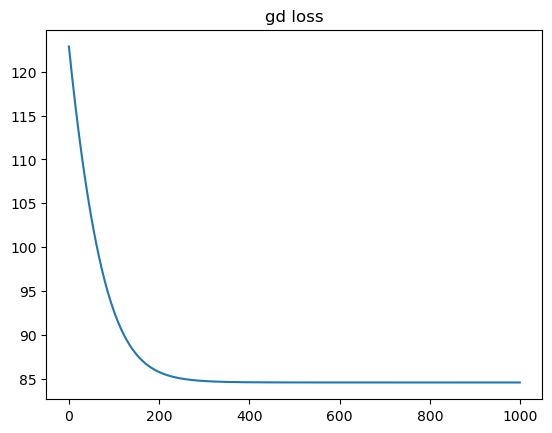

In [100]:
import matplotlib.pyplot as plt

plt.plot(lg.loss_array)
plt.title('gd loss')
plt.show()

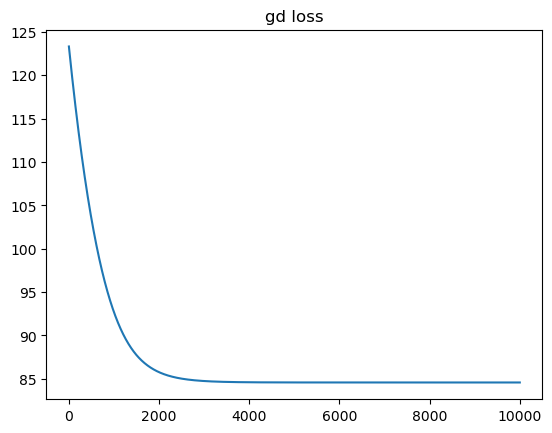

In [101]:
import matplotlib.pyplot as plt

plt.plot(lg_2.loss_array)
plt.title('gd loss')
plt.show()

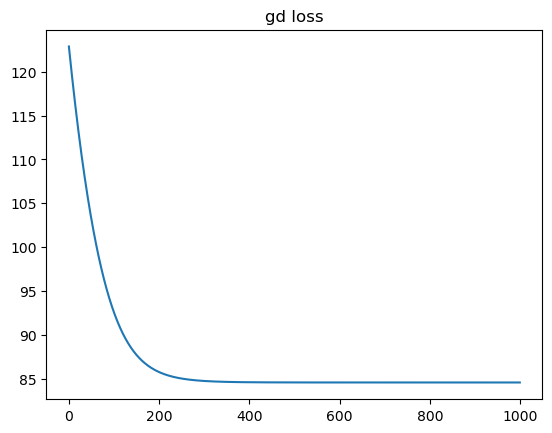

In [102]:
import matplotlib.pyplot as plt

plt.plot(lg_3.loss_array)
plt.title('gd loss')
plt.show()